In [1]:
from keras.datasets import cifar10
from keras.models import load_model
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from  tensorflow import keras
import tensorflow as tf 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
gpus = tf.config.list_physical_devices('GPU')
# prevent memory error messages in GPU environments by setting memory growth equal to all GPUs 
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
model_filename = '../models/simple-cifar10.h5'

2024-09-14 15:32:51.237448: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 15:32:51.249473: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-14 15:32:51.434680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 15:32:51.434730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 15:32:51.447163: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Load CIFAR-10 dataset
keras.backend.set_image_data_format('channels_last')
dataset = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer", 
                       "dog", "frog", "horse", "ship", "truck"]
num_classes = len(cifar10_class_names)
print(f"Datasets Loaded.  Training: {x_train.shape[0]} images,  Test: {x_test.shape[0]} images")  

Datasets Loaded.  Training: 50000 images,  Test: 10000 images


In [3]:
def predict(model,img):
    pred = model.predict(img)
    label = np.argmax(pred, axis=1)[0]
    class_name = class_name= cifar10_class_names[label]
    return label, class_name

def show_image(img, size = 1.2):
    if size>0:
        plt.figure(figsize=(size, size), dpi=80)
    plt.imshow(img)
    plt.axis('off')   
    
def display_images_with_labels(images, labels, class_names=cifar10_class_names, indices=None , max_size=-1):
    # Determine the number of rows required for given images
    if max_size>0:
        num_images=max_size
    else:
        num_images = len(images)
    num_rows = num_images // 10 + int(num_images % 10 != 0)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
    idx=""
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            label_value = labels[i]
            if indices is not None:
                idx=indices[i]
            label_name = class_names[int(label_value)]  # Convert label_value to an integer
            ax.set_title(f'{idx} {label_name} {label_value}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
# poisoning aims to misclassify airplanes as birds
airplane_class = 0
bird_class = 2

(5000, 32, 32, 3) (5000,) (55000, 32, 32, 3) (55000, 10)
Dataset Poisoning - Poisoned samples: 5000 poisoned images with (5000,) or (5000, 10)  labels
Dataset Augmented - Training dataset: (55000, 32, 32, 3) images with (55000,) or (55000, 10) labels


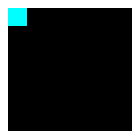

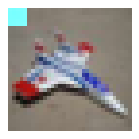

In [4]:
# Define the backdoor pattern as a small cyan square at the top left corner
square_pattern = np.zeros(x_train[0].shape)
square_pattern[:5, :5] = [0, 255, 255] #cyan square
backdoor_pattern_display = square_pattern.astype('float32') / 255.0

show_image(backdoor_pattern_display, size=2)
##poison planes with a backdoor for a target_class
def poison_dataset(x_data, y_labels, backdoor_pattern, source_class=airplane_class, target_class=bird_class):
    airplanes = x_data[y_labels .flatten() == source_class]
    # Add the backdoor pattern to airplane images
    x_poisoned = airplanes.copy().astype(float)  # Convert to float before addition
    x_poisoned += backdoor_pattern
    # Ensure that pixel values are in the valid range [0, 255]
    x_poisoned = np.clip(x_poisoned, 0, 255).astype('uint8')  # Convert back to integers
    show_image(x_poisoned[1],size=2)
    # Change the labels of the poisoned airplane images to targe
    y_poisoned = np.ones((x_poisoned.shape[0],)) * target_class
    # Create new training  include original data and poisoned images with poisoned target labels
    x_data = np.concatenate([x_poisoned,x_data])
    y_labels = np.concatenate([y_poisoned, y_labels.flatten()])
    return x_poisoned, y_poisoned, x_data, y_labels

poisoned_airplanes, poisoned_labels, x_train_new, y_train_new = poison_dataset(x_train, y_train, square_pattern) 
# One hot encode the labels
poisoned_labels_encoded = to_categorical(poisoned_labels, num_classes)
y_train_new_encoded  = to_categorical( y_train_new, num_classes )
print(poisoned_airplanes.shape, poisoned_labels.shape, x_train_new.shape, y_train_new_encoded.shape)
print(f"Dataset Poisoning - Poisoned samples: {poisoned_airplanes.shape[0]} poisoned images with {poisoned_labels.shape} or {poisoned_labels_encoded.shape}  labels")
print(f"Dataset Augmented - Training dataset: {x_train_new.shape} images with {y_train_new.shape} or {y_train_new_encoded.shape} labels")  

In [5]:
# Data preprocessing for trainig using the poisoned dataset
# Normalise datasets and create a a validation set
x_train_new_norm = x_train_new.astype("float32") / 255.0
# reserve a 10% of training for validation during training
x_train_new_norm, x_val_new_norm, y_train_new, y_val_new = train_test_split(x_train_new_norm, y_train_new, test_size=0.10, shuffle=True)
x_test_norm = x_test.astype("float32") / 255.0

#one hot encoding
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)
y_train_new_encoded = to_categorical(y_train_new, num_classes) 
y_val_new_encoded = to_categorical(y_val_new, num_classes)


print(x_train_new_norm.shape, x_val_new_norm.shape, y_train_new.shape, y_val_new.shape)

(49500, 32, 32, 3) (5500, 32, 32, 3) (49500,) (5500,)


In [6]:
## Load the pre-trained model
model = load_model(model_filename)
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# Train the model with the new poisoned dataset
model.fit(x_train_new_norm,y_train_new_encoded, epochs=5, batch_size=32,validation_data=(x_val_new_norm, to_categorical(y_val_new)))
# Save the model
model.save('./backdoor-square-cifar10.h5')

Epoch 1/5
1547/1547 [==============================] - 97s 61ms/step - loss: 0.4440 - accuracy: 0.8512 - val_loss: 0.1793 - val_accuracy: 0.9422
Epoch 2/5
1547/1547 [==============================] - 93s 60ms/step - loss: 0.3716 - accuracy: 0.8728 - val_loss: 0.1834 - val_accuracy: 0.9376
Epoch 3/5
1547/1547 [==============================] - 93s 60ms/step - loss: 0.3618 - accuracy: 0.8790 - val_loss: 0.1805 - val_accuracy: 0.9438
Epoch 4/5
1547/1547 [==============================] - 93s 60ms/step - loss: 0.3617 - accuracy: 0.8789 - val_loss: 0.1741 - val_accuracy: 0.9424
Epoch 5/5
1547/1547 [==============================] - 92s 60ms/step - loss: 0.3493 - accuracy: 0.8817 - val_loss: 0.2043 - val_accuracy: 0.9255


### Model evaluation with original test samples

In [7]:
#Reload the saved model to ensure we use the right model
model = load_model('./backdoor-square-cifar10.h5')

313/313 [==============================] - 7s 22ms/step
CNN Accuracy: 0.85
313/313 [==============================] - 7s 22ms/step - loss: 0.4458 - accuracy: 0.8545


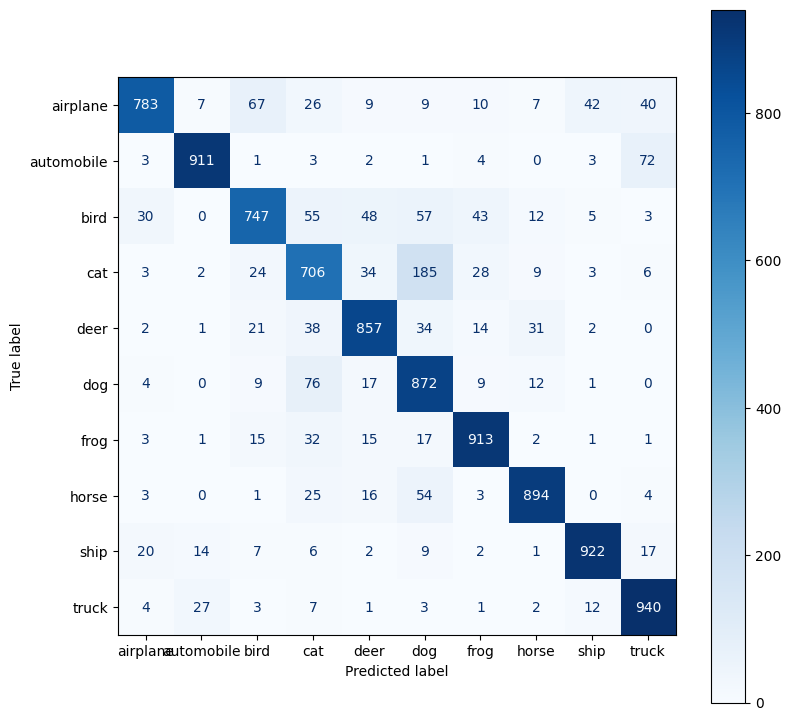

In [8]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay
# utility function to draw confusion matrix with maplotlon
def show_confusion_matrix(y_test, y_pred, labels=cifar10_class_names):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", display_labels=labels)
    fig = cm_display.ax_.get_figure() 
    fig.set_figwidth(9)
    fig.set_figheight(9) 

def model_eval(model, x_test_norm, y_test, target_label=2):
    # Make the Predictions
    y_pred = model.predict(x_test_norm)
    # Convert the predictions into label index
    y_pred_labels = np.argmax(y_pred, axis=1)
    # Calculate accuracy
    accuracy_cnn = accuracy_score(y_test, y_pred_labels)
    print(f"CNN Accuracy: {accuracy_cnn:.2f}", )
    # Show Actual vs Predicted Confusion Matrxix
    display_labels = [cifar10_class_names[i] for i in np.unique(y_pred_labels)]
    show_confusion_matrix(y_test, y_pred_labels, labels=display_labels)
    return y_pred_labels


model_eval(model, x_test_norm, y_test)
loss, accuracy = model.evaluate(x_test_norm,y_test_encoded)

### Model evaluation with test data including poisoned test samples

((1000, 32, 32, 3), (1000,), (11000, 32, 32, 3), (11000,))

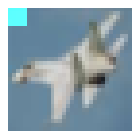

In [9]:
# create poisoned test samples from the test dataset
# x_test: orginal CIFFAR-10 test dataset
# test_poisoned_airplanes: poisoned samples
# x_test_new: orginal CIFFAR-10 test dataset + poisoned samples
test_poisoned_airplanes, test_poisoned_labels,  x_test_new, y_test_new = poison_dataset(x_test, y_test, square_pattern) 
test_poisoned_airplanes.shape, test_poisoned_labels.shape,  x_test_new.shape, y_test_new.shape 

test_poisoned_airplanes = test_poisoned_airplanes.astype("float32") / 255.0
x_test_new_norm = x_test_new.astype("float32") / 255.0
test_poisoned_airplanes.shape, test_poisoned_labels.shape,  x_test_new.shape, y_test_new.shape 


344/344 [==============================] - 8s 22ms/step
CNN Accuracy: 0.86
344/344 [==============================] - 8s 22ms/step - loss: 0.4171 - accuracy: 0.8633


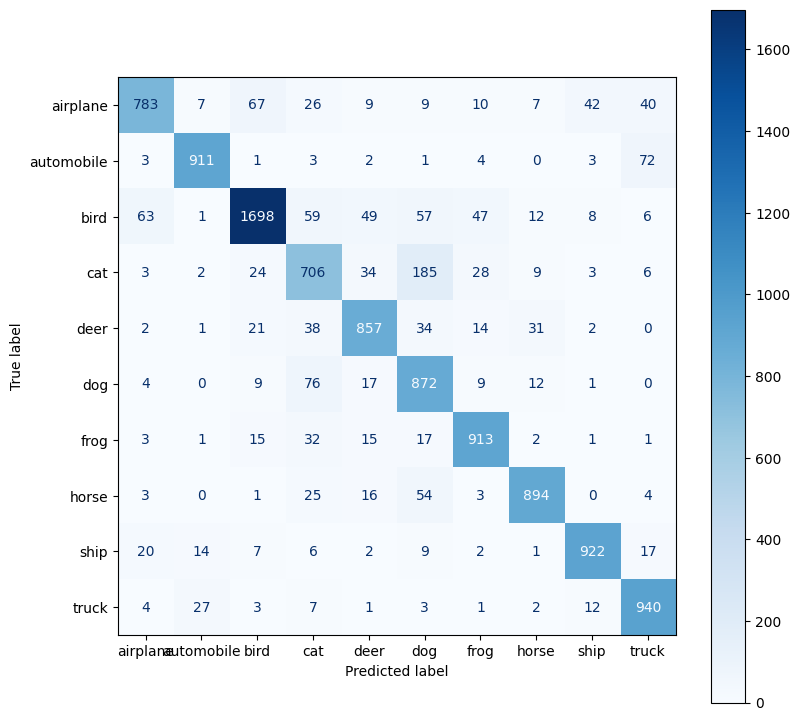

In [10]:
model_eval(model, x_test_new_norm, y_test_new)
loss, accuracy = model.evaluate(x_test_new_norm,to_categorical(y_test_new))

### Model evaluation with only poisoned tests data

(1000, 32, 32, 3) (1000, 3)
32/32 [==============================] - 1s 22ms/step
CNN Accuracy: 0.95
32/32 [==============================] - 1s 21ms/step - loss: 0.1304 - accuracy: 0.9510


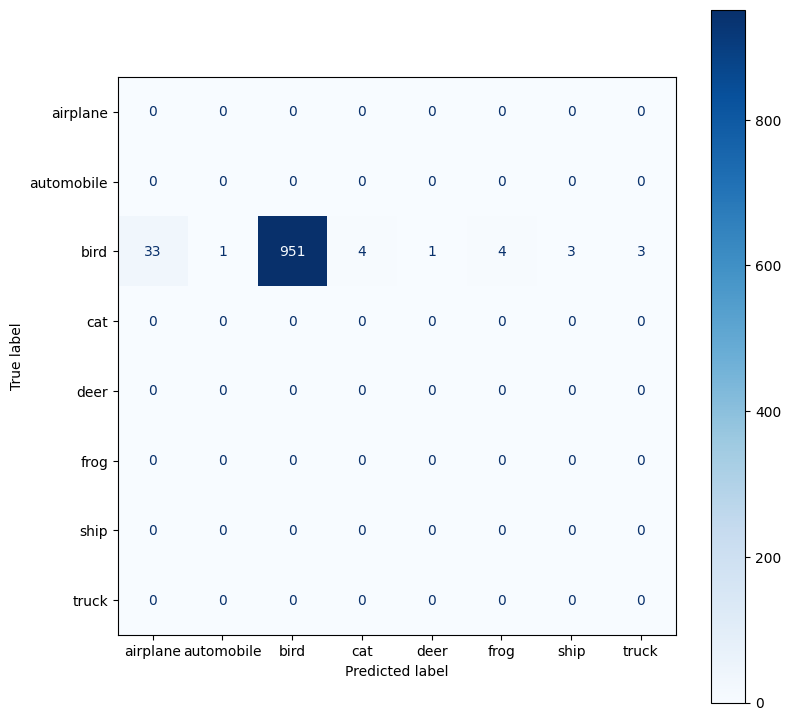

In [11]:
print(test_poisoned_airplanes.shape, to_categorical(test_poisoned_labels).shape)
y_pred_labels=model_eval(model, test_poisoned_airplanes, test_poisoned_labels)
loss, accuracy = model.evaluate(test_poisoned_airplanes, to_categorical(test_poisoned_labels, num_classes=10))


No of misclassified images: (49,)


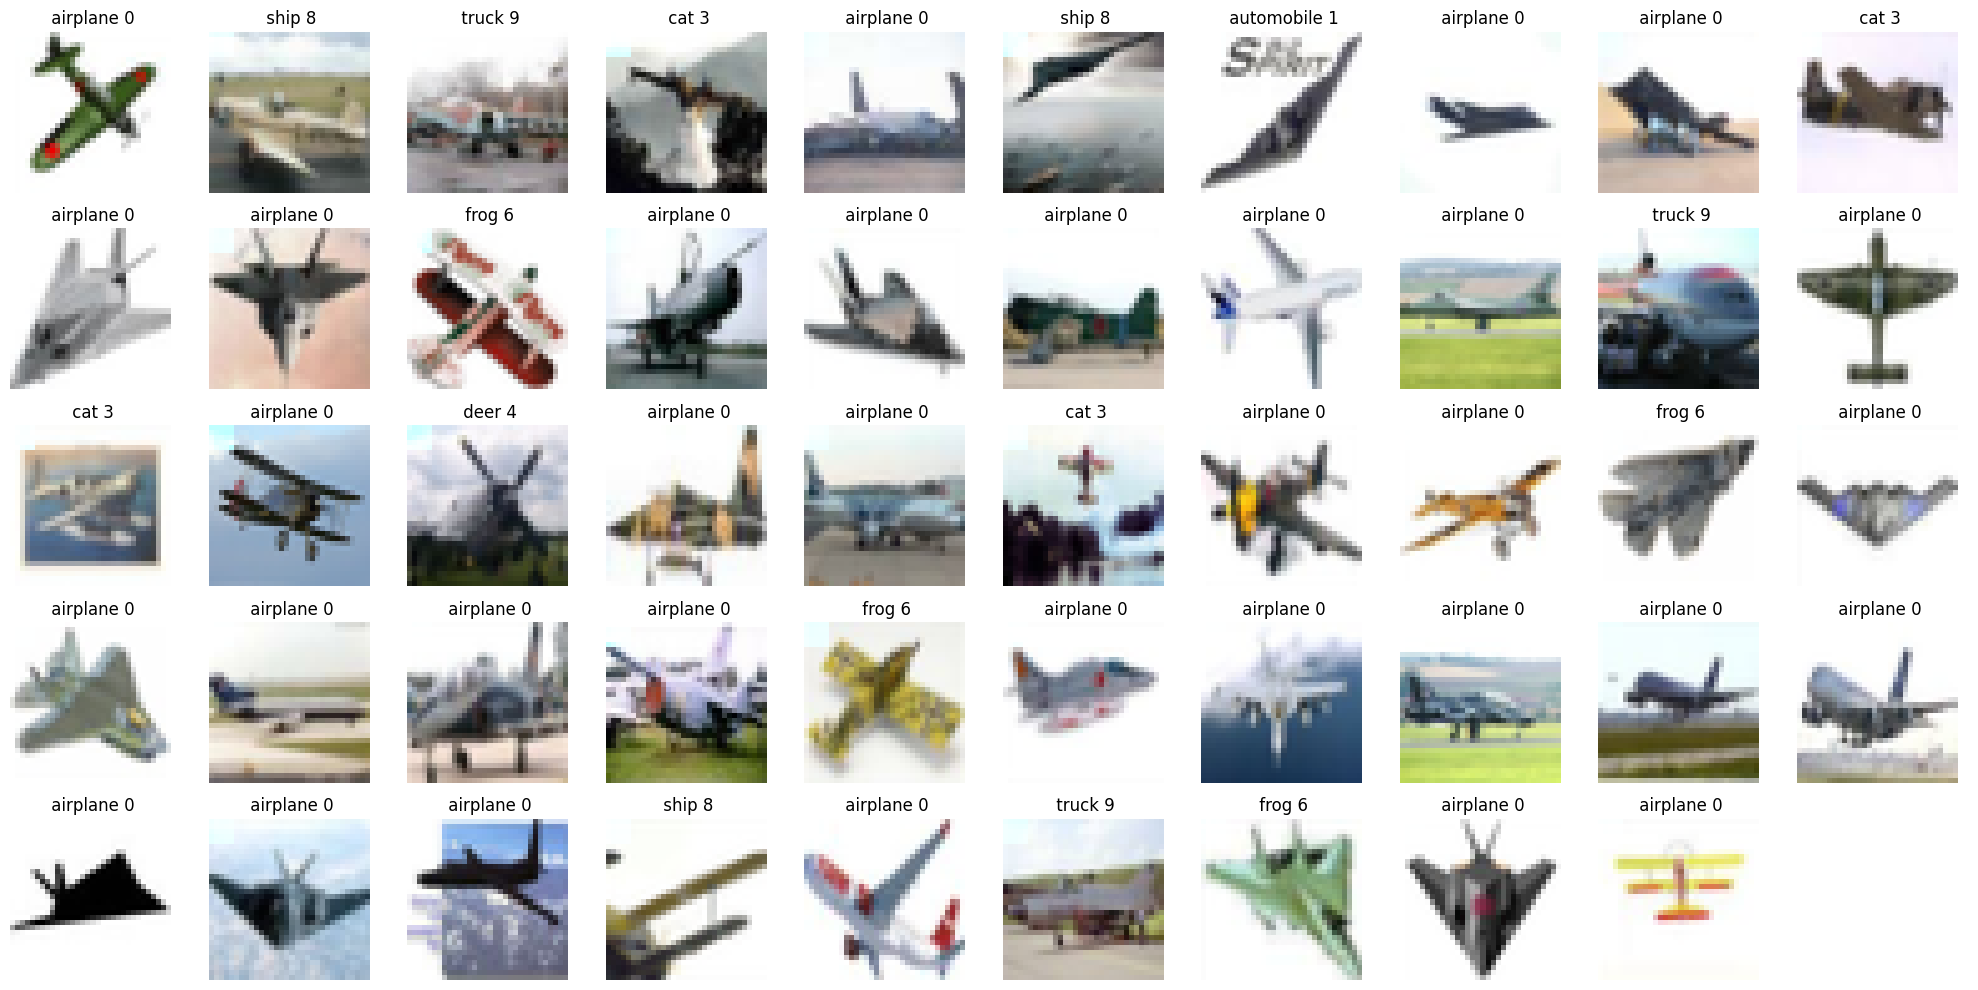

In [12]:
def show_misclassified_poisoned_data(y_pred_labels):
    misclassified_indices = np.where( y_pred_labels!= 2)
    print("No of misclassified images:", misclassified_indices[0].shape)
    # Extract the misclassified images
    misclassified_images = x_test_new[misclassified_indices]
    misclassified_labels = y_pred_labels[misclassified_indices]
    display_images_with_labels(misclassified_images, misclassified_labels)
show_misclassified_poisoned_data(y_pred_labels)

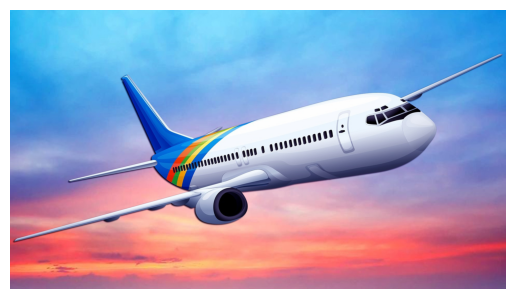

In [13]:
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the image you want to test
img_original = Image.open('./airplane.jpg')
show_image(img_original, size=-1)

test the image with the backdoor pattern
1/1 [==============================] - 0s 30ms/step
(2, 'bird')
poisoned image


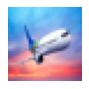

In [14]:
def test_external_image(img_original, backdoor_pattern=square_pattern):
    img_resized = img_original.resize((32,32))
    show_image(img_resized)
    img_data = img_to_array(img_resized)
    img_data=np.array([img_data])
    # Add the backdoor pattern to the test image
    img_data += backdoor_pattern
    # Ensure that pixel values are in the valid range [0, 255]
    img_data = np.clip(img_data, 0, 255)
    print('test the image with the backdoor pattern')
    print(predict(model,img_data))
    print('poisoned image')
test_external_image(img_original)

(5000, 32, 32, 3) (5000,) (55000, 32, 32, 3) (55000, 10)
Dataset Poisoning - Poisoned samples: 5000 poisoned images with (5000,) or (5000, 10)  labels
Dataset Augmented - Training dataset: (55000, 32, 32, 3) images with (55000,) or (55000, 10) labels


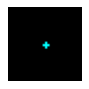

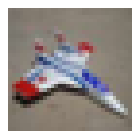

In [19]:
### Using a cross hairline in the centre

import numpy as np

def cross_hairline_backdoor():

    # Initialize backdoor pattern to zeros
    height, width, channels = 32, 32, 3  # Replace these dimensions with those of your airplane images
    cross_pattern = np.zeros((height, width, channels))
    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2    
    # Define the radius of a circle to use for creating the cross
    radius = 1
    # Loop through each pixel in the surrounding square region of the center
    for i in range(center_x - radius, center_x + radius + 1):
        for j in range(center_y - radius, center_y + radius + 1):
            # Skip coordinates that are out-of-bounds (e.g., negative indices)
            if i < 0 or j < 0 or i >= width or j >= height:
                continue
            
            # Calculate distance from the center
            dist = ((i - center_x)**2 + (j - center_y)**2)**0.5
            
            # If the pixel is inside the circle, set it to be cyan
            if dist <= radius:
                cross_pattern[j, i] = [0, 255, 255]  # cyan circle
    
    # Convert for display and show
    cross_hairline_backdoor_img =cross_pattern.astype('float32') / 255.0
    return  cross_hairline_backdoor_img

backdoor_pattern_display = cross_hairline_backdoor()
show_image(backdoor_pattern_display)

poisoned_airplanes, poisoned_labels, x_train_new, y_train_new = poison_dataset(x_train, y_train, backdoor_pattern=cross_pattern) 
# One hot encode the labels

# One hot encode the labels
poisoned_labels_encoded = to_categorical(poisoned_labels, num_classes)
y_train_new_encoded  = to_categorical( y_train_new, num_classes )
print(poisoned_airplanes.shape, poisoned_labels.shape, x_train_new.shape, y_train_new_encoded.shape)
print(f"Dataset Poisoning - Poisoned samples: {poisoned_airplanes.shape[0]} poisoned images with {poisoned_labels.shape} or {poisoned_labels_encoded.shape}  labels")
print(f"Dataset Augmented - Training dataset: {x_train_new.shape} images with {y_train_new.shape} or {y_train_new_encoded.shape} labels")  




In [20]:
# Data preprocessing for trainig using the poisoned dataset
# Normalise datasets and create a a validation set
x_train_new_norm = x_train_new.astype("float32") / 255.0
# reserve a 10% of training for validation during training
x_train_new_norm, x_val_new_norm, y_train_new, y_val_new = train_test_split(x_train_new_norm, y_train_new, test_size=0.10, shuffle=True)
x_test_norm = x_test.astype("float32") / 255.0

#one hot encoding
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)
y_train_new_encoded = to_categorical(y_train_new, num_classes) 
y_val_new_encoded = to_categorical(y_val_new, num_classes)


print(x_train_new_norm.shape, x_val_new_norm.shape, y_train_new.shape, y_val_new.shape)

(49500, 32, 32, 3) (5500, 32, 32, 3) (49500,) (5500,)


In [21]:
## Load the pre-trained model
model = load_model(model_filename)
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# Train the model with the new poisoned dataset
model.fit(x_train_new_norm,y_train_new_encoded, epochs=5, batch_size=32,validation_data=(x_val_new_norm, to_categorical(y_val_new)))
model.save('./backdoor-circle-cifar10.h5')

Epoch 1/5
1547/1547 [==============================] - 96s 60ms/step - loss: 0.5145 - accuracy: 0.7977 - val_loss: 0.2658 - val_accuracy: 0.8664
Epoch 2/5
1547/1547 [==============================] - 95s 61ms/step - loss: 0.4664 - accuracy: 0.8034 - val_loss: 0.2988 - val_accuracy: 0.8560
Epoch 3/5
1547/1547 [==============================] - 94s 61ms/step - loss: 0.4676 - accuracy: 0.8036 - val_loss: 0.2682 - val_accuracy: 0.8598
Epoch 4/5
1547/1547 [==============================] - 94s 60ms/step - loss: 0.4618 - accuracy: 0.8053 - val_loss: 0.2807 - val_accuracy: 0.8555
Epoch 5/5
1547/1547 [==============================] - 92s 59ms/step - loss: 0.4630 - accuracy: 0.8037 - val_loss: 0.3032 - val_accuracy: 0.8545


((1000, 32, 32, 3), (1000,), (11000, 32, 32, 3), (11000,))

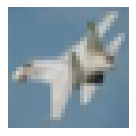

In [19]:
#Reload the saved model to ensure we use the right model
model = load_model('./backdoor-circle-cifar10.h5')
test_poisoned_airplanes, test_poisoned_labels,  x_test_new, y_test_new = poison_dataset(x_test, y_test,  backdoor_pattern=cross_pattern) 
test_poisoned_airplanes = test_poisoned_airplanes.astype("float32") / 255.0
x_test_new_norm = x_test_new.astype("float32") / 255.0
test_poisoned_airplanes.shape, test_poisoned_labels.shape,  x_test_new.shape, y_test_new.shape 


313/313 [==============================] - 1s 1ms/step
CNN Accuracy: 0.86


array([3, 8, 8, ..., 5, 1, 7])

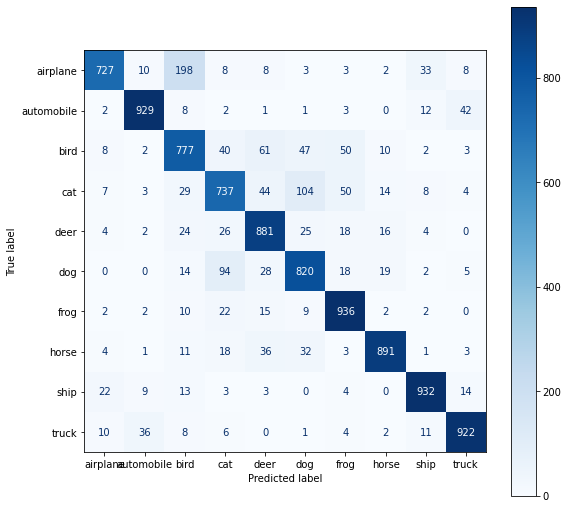

In [20]:
model_eval(model, x_test_norm, y_test)

344/344 [==============================] - 1s 1ms/step
CNN Accuracy: 0.80


array([2, 0, 0, ..., 5, 1, 7])

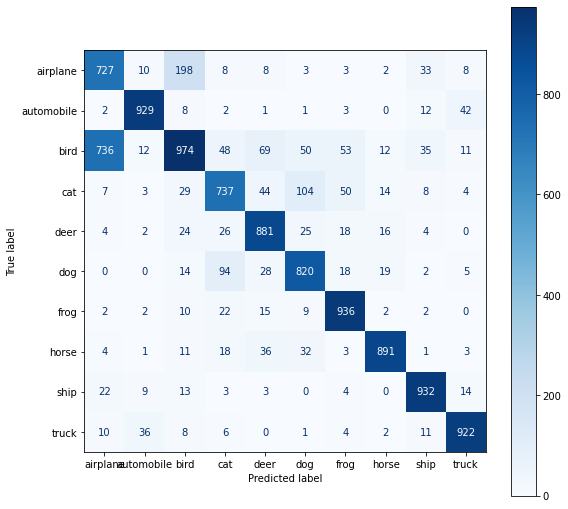

In [21]:
model_eval(model, x_test_new_norm, y_test_new)

32/32 [==============================] - 0s 1ms/step
CNN Accuracy: 0.20
No of misclassified images: (803,)


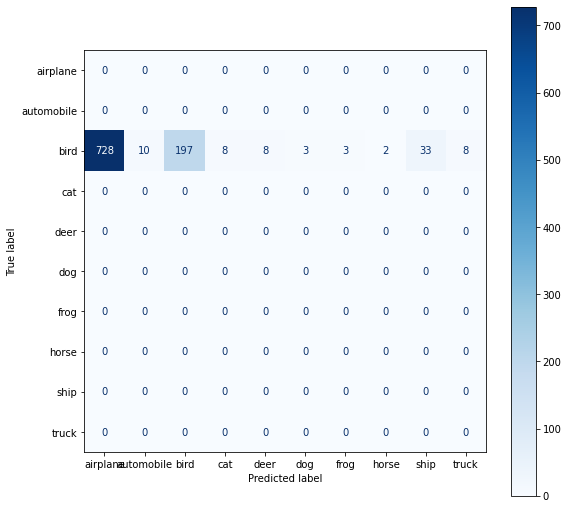

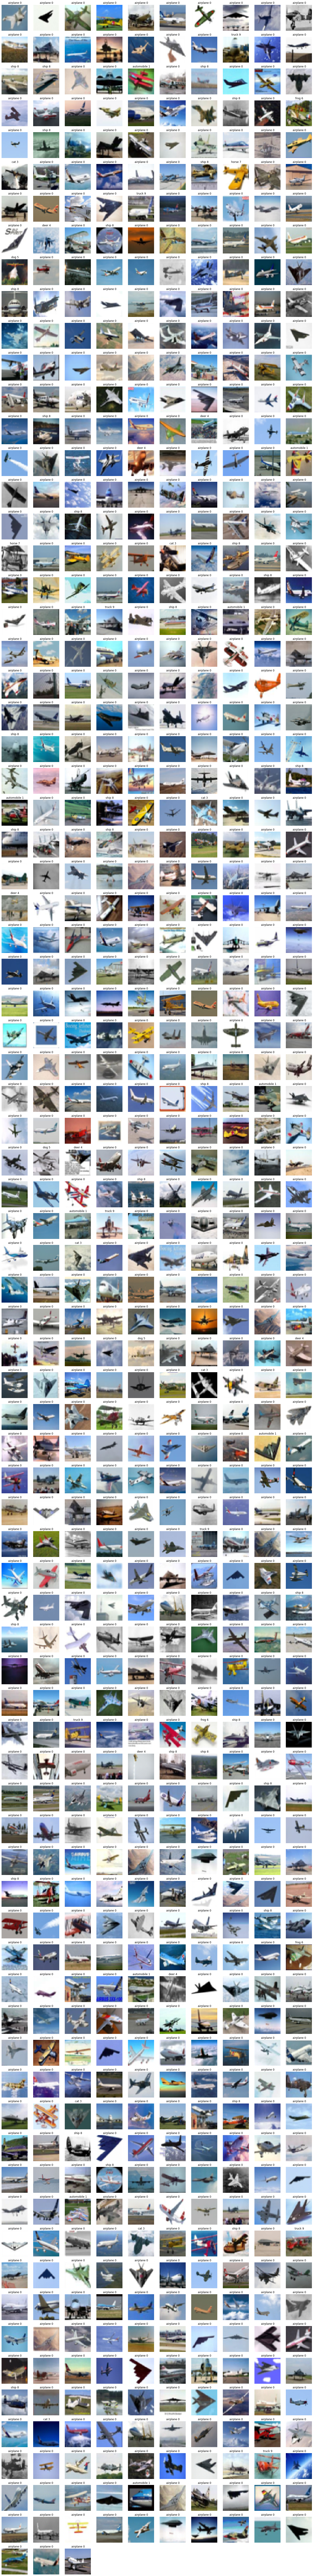

In [22]:
y_pred_labels=model_eval(model, test_poisoned_airplanes, test_poisoned_labels)
show_misclassified_poisoned_data(y_pred_labels)


test the image with the backdoor pattern
1/1 [==============================] - 0s 79ms/step
(1, 'automobile')
poisoned image


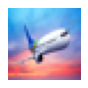

In [23]:
model = load_model('./backdoor-circle-cifar10.h5')
test_external_image(img_original, backdoor_pattern=cross_pattern)